# Stock Portfolio Analysis with Yahoo Finance
This notebook implements a Portfolio class to track and analyze multiple stocks using real market data from Yahoo Finance.

## Initial Imports
First, we import all necessary libraries:
- yfinance: To download stock data
- pandas: For data manipulation
- datetime: For date handling
- matplotlib: For visualization

In [6]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from pandas.errors import OutOfBoundsDatetime
import matplotlib.pyplot as plt

import io
from contextlib import redirect_stdout

## Utility Function
This helper function runs operations silently by capturing stdout, useful for suppressing yfinance download messages:

In [2]:
def run_function_silently(func):
    with io.StringIO() as fake_stdout:
        with redirect_stdout(fake_stdout):
            result = func()

        return result, fake_stdout.getvalue()

## Stock Class
Creates a custom DataFrame class that inherits from pandas.DataFrame:
- Initializes with a ticker symbol
- Downloads historical data using yfinance
- Implements a price method to get stock price for any date

In [3]:
class Stock(pd.DataFrame):
    """ stock dataframe holding the data from a stock. Uses yfiance"""
    def __init__(self, ticker=None, *args, **kwargs):
        if isinstance(ticker, str):
            downloaded_data = self.download(ticker, **kwargs)
        super(Stock, self).__init__(downloaded_data, *args)

    def download(self, ticker, start=None, end=None, interval="1d", *args, **kwargs):
        param_dict = {
            'tickers': ticker,
            'start': start,
            'end': end,
            'interval': interval
        }
        param_dict.update(kwargs)
        donwloaded, _ = run_function_silently(lambda: yf.download(**param_dict))
        return donwloaded

    def price(self, date):
        """Returns the adjusted close price for a given date or the nearest available date."""
        # Ensure the date is in datetime format
        if not isinstance(date, pd.Timestamp):
            date = pd.to_datetime(date)

        # Try to get the price for the exact date
        if date in self.index:
            return self.loc[date, "Adj Close"]

        # If date is not found, get the closest available date
        nearest_idx = self.index.get_indexer([date], method='nearest')[0]
        if nearest_idx >= 0:  # Ensure that the index is valid
            nearest_date = self.index[nearest_idx]
            return self.loc[nearest_date, "Adj Close"]
        
        # If no valid date is available in the index
        print("not found!")
        return None

## Portfolio Class
Manages a collection of stocks and provides analysis methods:
- add_stock: Adds a stock with specified number of shares
- load_data: Downloads historical data for all stocks
- profit: Calculates total or annualized returns between dates
- plot_portfolio: Visualizes portfolio value over time

In [4]:
class Portfolio:
    def __init__(self):
        self.stocks = {}

    def add_stock(self, ticker, shares):
        if ticker not in self.stocks: self.stocks[ticker] = {'stock': None, 'shares': shares}
        else: self.stocks[ticker]["shares"] += shares
    def load_data(self, start, end):
        for stock_ticker, stock_info in zip(self.stocks.keys(), self.stocks.values()):
            stock_info['stock'] = Stock(ticker=stock_ticker, start=start, end=end)
    def profit(self, start_date, end_date, annualized=False):
        start_price = 0.0
        end_price = 0.0

        for stock_info in self.stocks.values():
            stock = stock_info['stock']
            shares = stock_info['shares']
            start_price += stock.price(start_date) * shares
            end_price += stock.price(end_date) * shares

        # calculate total return
        profit = end_price - start_price
        if not annualized:
            return profit

        # calculate annualized return
        days_diff = (end_date - start_date).days
        annualized_return = ((end_price / start_price) ** (365.25 / days_diff)) - 1
        return annualized_return

    def plot_portfolio(self, start_date, end_date):
        date_range = pd.date_range(start=start_date, end=end_date)
        portfolio_values = []

        for date in date_range:
            total_value = sum(
                stock_info['stock'].price(date) * stock_info['shares']
                for stock_info in self.stocks.values()
            )
            portfolio_values.append(total_value)

        plt.figure(figsize=(12, 6))
        plt.plot(date_range, portfolio_values, label='Portfolio Value')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value (USD)')
        plt.title('Portfolio Value Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

## Create and Initialize Portfolio
Create a sample portfolio with AAPL, MSFT, and GOOGL stocks:

In [7]:
# dates for analysis
start_date = datetime(2021, 1, 1)
end_date = datetime(2024, 1, 1)

portfolio = Portfolio()
portfolio.add_stock('AAPL', 10)  
portfolio.add_stock('MSFT', 5)  
portfolio.add_stock('GOOGL', 8)  

portfolio.load_data(start=start_date, end=end_date)

In [8]:
profit = portfolio.profit(start_date, end_date)
annualized_return = portfolio.profit(start_date, end_date, annualized=True)
print(f"Profit: ${profit:.2f}")
print(f"Annualized Return: {annualized_return * 100:.2f}%")

Profit: $1892.96
Annualized Return: 17.67%


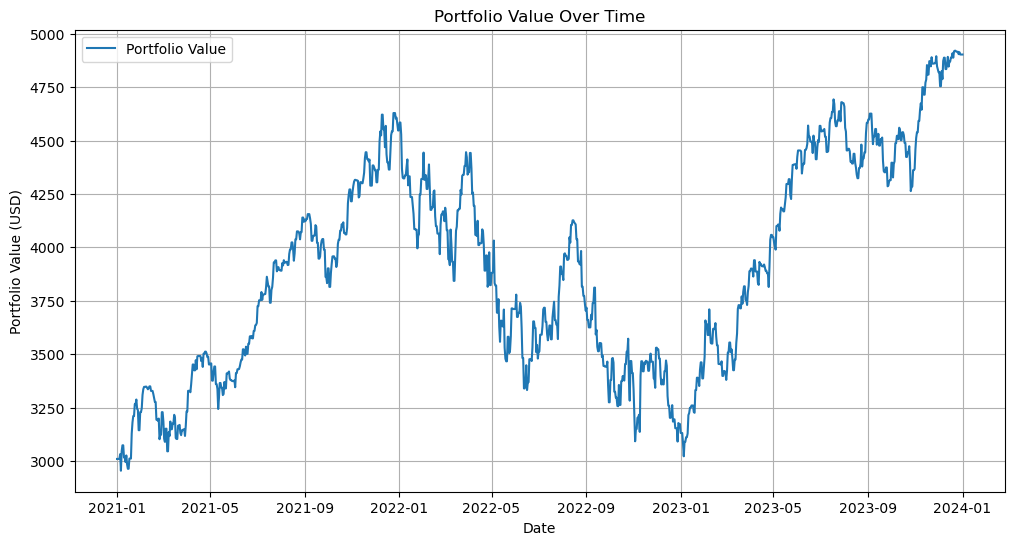

In [9]:
portfolio.plot_portfolio(start_date, end_date)